In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic

/tmp/ipykernel_43926/251887701.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [41]:
# Generated
gen_to = Traffic.from_file("../deep_traffic_generation/data/generated_datasets/gen_takeoffs_LFPO_07.pkl")
gen_ldng = Traffic.from_file("../deep_traffic_generation/data/generated_datasets/gen_landings_LFPO_06.pkl")

# #make every flight begin at the same time
# base_ts = pd.Timestamp.today(tz = "UTC").round(freq='T')
# gen_to.data = gen_to.data.assign(
#     timestamp=pd.to_timedelta(gen_to.data.timedelta, unit="s") + base_ts
# )
# gen_ldng.data = gen_ldng.data.assign(
#     timestamp=pd.to_timedelta(gen_ldng.data.timedelta, unit="s") + base_ts
# )

# gen_to.to_pickle("../deep_traffic_generation/data/generated_datasets/gen_takeoffs_LFPO_07.pkl")
# gen_ldng.to_pickle("../deep_traffic_generation/data/generated_datasets/gen_landings_LFPO_06.pkl")

# Observed
obs_to = Traffic.from_file("../deep_traffic_generation/data/training_datasets/takeoffs_LFPO_07.pkl")
obs_ldng = Traffic.from_file("../deep_traffic_generation/data/training_datasets/landings_LFPO_06.pkl")

# Estimation of timedelta between two consecutive flights of a same flow

Methods to estimate the time between 2 consicutive aircrafts:
- Select the days where there are more than 100 movements for the considered flow going south (200 if we take all departures)
- For each of those days, select the busiest hours (between 4 and 21)
- Calculate the time difference between aircrafts for each selected days
- Aggregate all delta_t
- Estimate the distribution with either exponential, Birnbaum-Sanders or KDE

Should we only estimate delta_t for aircraft going south, or for every aircraft, and estimating a second radom variable (bernoulli) that tells if an aircraft is goind south or not ? Are those two variables independant ? if not, should we estimate the joint distribution ?

## Take-offs

In [3]:
#Select only the south flow

last_track = obs_to.data.groupby("flight_id")["track"].last()
id_to_south = last_track[(last_track > 130) & (last_track < 210)].index
print("Total take-offs: ", len(obs_to))
print("Take-offs to south: ", len(id_to_south))
print("Ratio: ", len(id_to_south)/len(obs_to))
obs_to = obs_to[id_to_south]

Total take-offs:  7430
Take-offs to south:  5323
Ratio:  0.7164199192462988


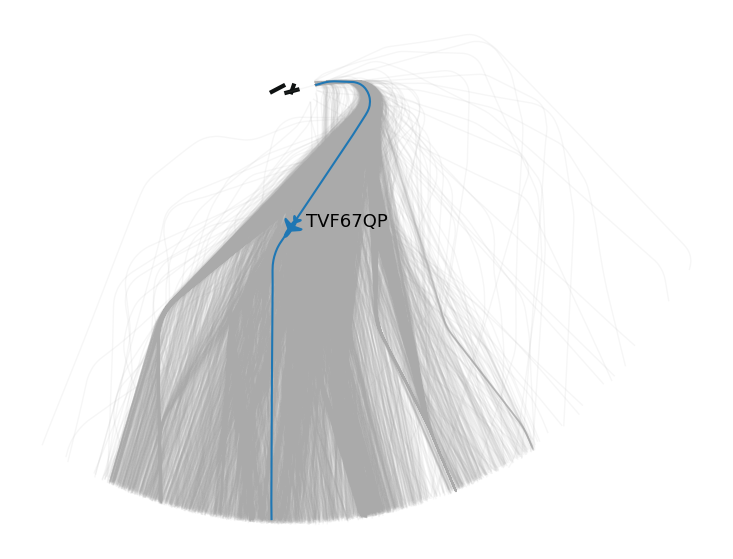

In [90]:
#Trajecotires are already normalized to begin at the same point

from traffic.core.projection import Lambert93
from traffic.data import airports

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    obs_to.plot(ax, alpha=0.1)

    k = 4000
    obs_to[k].plot(ax, color="#1f77b4", lw=1.5)
    obs_to[k].at_ratio(0.5).plot(
        ax,
        color="#1f77b4",
        zorder=3,
    )

    airports["LFPO"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

plt.show()

In [4]:
start_time = obs_to.data.groupby("flight_id")["timestamp"].first().sort_values()

df_start_time = start_time.to_frame()
df_start_time["year"] = start_time.dt.year
df_start_time["month"] = start_time.dt.month
df_start_time["day"] = start_time.dt.day
df_start_time["hour"] = start_time.dt.hour
df_start_time["day_name"] = start_time.dt.day_name()
df_start_time = df_start_time.reset_index()
df_start_time.index = df_start_time.timestamp

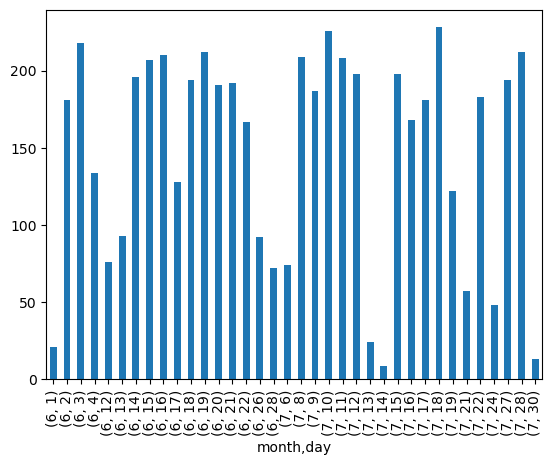

In [92]:
df_start_time.groupby(["month", "day"]).timestamp.count().plot.bar()
plt.show()

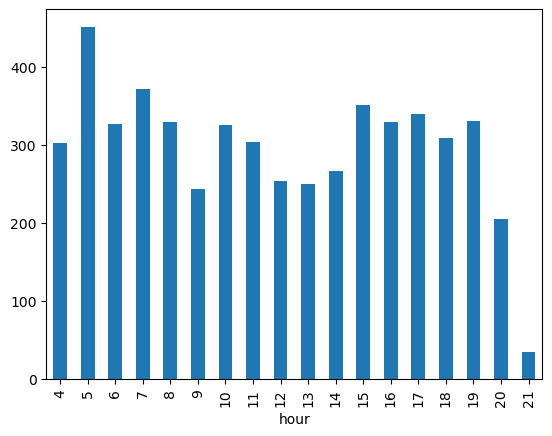

In [93]:
df_start_time.groupby(["hour"]).timestamp.count().plot.bar()
plt.show()

In [5]:
busy_days = df_start_time.groupby(["year", "month", "day"]).timestamp.count() > 120
busy_days = busy_days[busy_days==True].reset_index()[["year", "month", "day"]]
busy_days = pd.to_datetime(busy_days).astype(str)

#For every busiest days of the dataset (more than 200 movements)
#Get the time difference between two consecutives flights

dt_sec = {}
for i in tqdm(busy_days):
    delta_t = np.diff(df_start_time.loc[i].between_time('04:00','21:00').timestamp)
    helper = np.vectorize(lambda x: x.total_seconds())
    dt_sec[i] = helper(delta_t)

  0%|          | 0/25 [00:00<?, ?it/s]

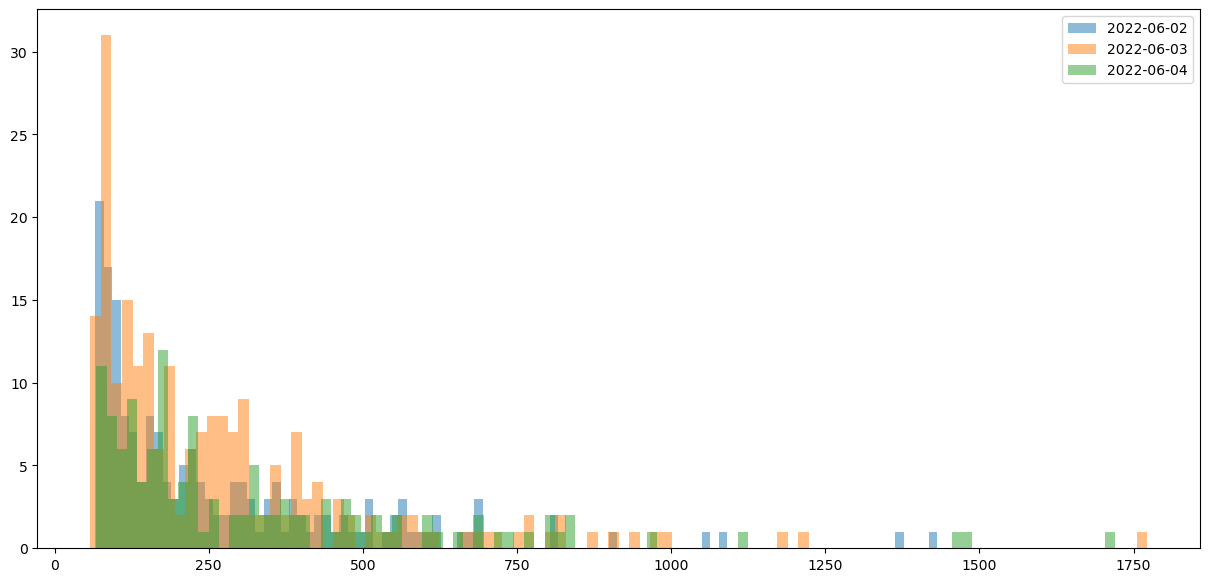

In [6]:
day1 = dt_sec[busy_days[0]][dt_sec[busy_days[0]] < 2000]
day2 = dt_sec[busy_days[1]][dt_sec[busy_days[1]] < 2000]
day3 = dt_sec[busy_days[2]][dt_sec[busy_days[2]] < 2000]

plt.figure(figsize=(15,7))
plt.hist(day1, 100, alpha=0.5, label=busy_days[0])
plt.hist(day2, 100, alpha=0.5, label=busy_days[1])
plt.hist(day3, 100, alpha=0.5, label=busy_days[2])
plt.legend(loc='upper right')
plt.show()

In [7]:
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

#Will the estimation be imporved with more samples ?
# https://stackoverflow.com/questions/37559470/what-do-all-the-distributions-available-in-scipy-stats-look-like/37559471#37559471

agg_delta_t = np.array([x for v in dt_sec.values() for x in v])
x = agg_delta_t[agg_delta_t < 2000] #ATTENTION : sometime no takeoff for hours

#Exponential Law: waiting time between two events of a Poisson process -> Should be the one we use
dist_exp = st.expon
args_exp = dist_exp.fit(x) #x or agg_delta_t
print(st.kstest(x, dist_exp.cdf, args_exp)) #goodness of fit with KS test: p value very low: Reject the null hypothesis which states that the sample comes from an exponential distribution

#Other test: Birnbaum-Sanders distribution, which is typically used to model failure times
dist_fl = st.fatiguelife
args_fl = dist_fl.fit(x)
print(st.kstest(x, dist_fl.cdf, args_fl))

#KDE: Gaussian
kde = KernelDensity(kernel="gaussian", bandwidth=11).fit(x.reshape(-1, 1))
# kernels = ['epanechnikov', 'exponential', 'gaussian']
# params = {"bandwidth": np.logspace(-1, 2, 20), "kernel": kernels}
# grid = GridSearchCV(KernelDensity(), params)
# grid.fit(x.reshape(-1, 1))
# print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
# # use the best estimator to compute the kernel density estimate
# kde = grid.best_estimator_


KstestResult(statistic=0.08555028768669568, pvalue=3.28203939566856e-30)
KstestResult(statistic=0.04411187041292575, pvalue=2.4291033100125352e-08)


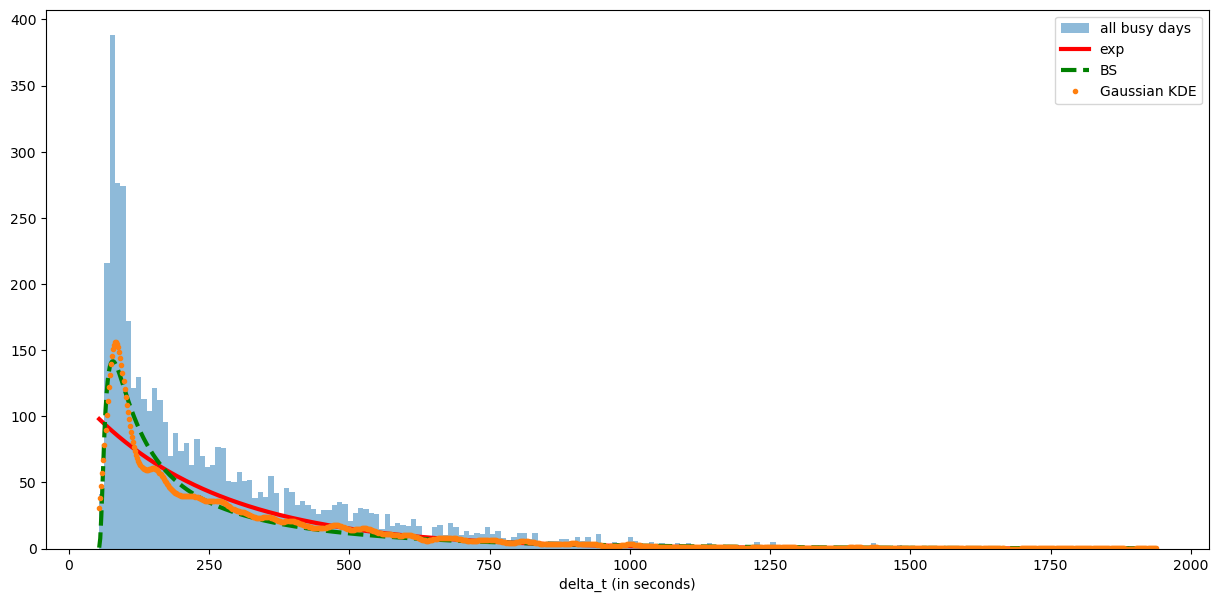

In [8]:
seconds = np.linspace(x.min(), x.max(), 1000)
dist_1 = dist_fl.pdf(seconds, *args_fl)
dist_2 = dist_exp.pdf(seconds, *args_exp)
log_dens = kde.score_samples(seconds[:, np.newaxis])
nbins = 200

fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.hist(x, nbins, alpha=0.5, label="all busy days")
ax.plot(seconds, dist_2 * len(x) * 1000 / nbins,
        '-r', lw=3, label='exp')
ax.plot(seconds, dist_1 * len(x) * 1000 / nbins,
        '--g', lw=3, label='BS')
ax.plot(seconds, np.exp(log_dens)* len(x) * 1000 / nbins,
        '.', lw=3, label='Gaussian KDE')
ax.set_xlabel("delta_t (in seconds)")
ax.legend()
plt.show()

Parameters for BS distribution:  (1.2915832344015081, 49.84875673178755, 131.49841685902197)
2 sample KS test for BS:  KstestResult(statistic=0.050706033376123234, pvalue=1.2030679469634164e-05)
2 sample KS test for Gaussian KDE:  KstestResult(statistic=0.02503209242618742, pvalue=0.10691165219414905)


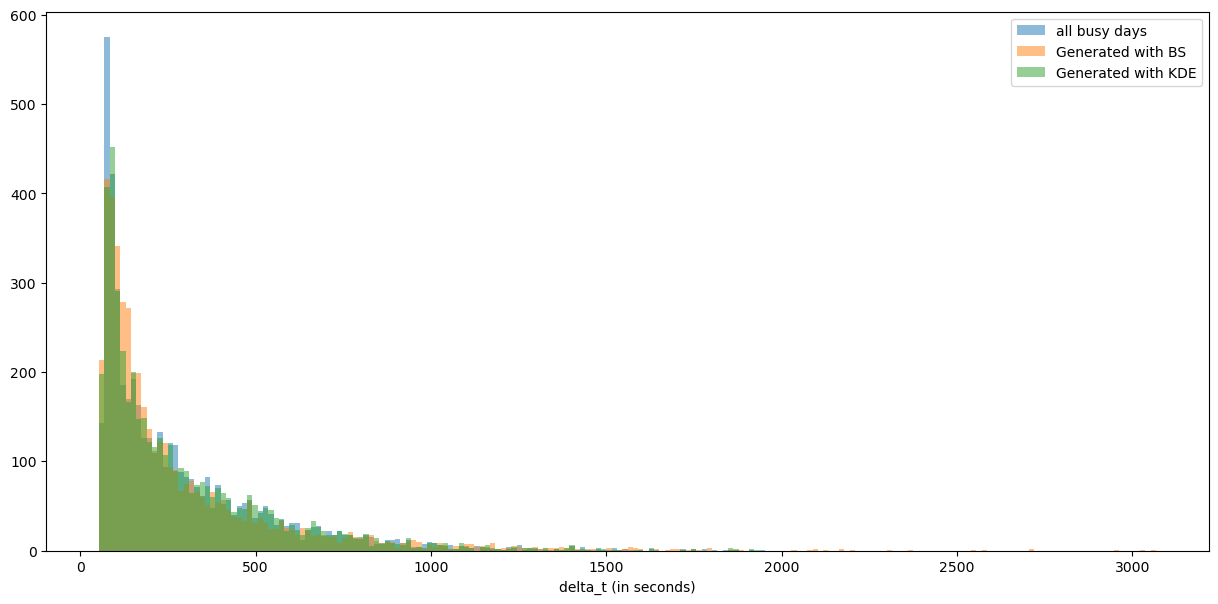

In [9]:
#WARNING: Loc and scale are different from mean and std
#WARNING: Bins cut in equal parts between min and max values. If for second distrib, they are different, bins are not the same size
y = dist_fl(*args_fl).rvs(size = len(x))
z = kde.sample(len(x))
print("Parameters for BS distribution: ", args_fl)
bins=np.histogram(np.hstack((x,y)), bins=200)[1]

print("2 sample KS test for BS: ", st.kstest(x, y))
print("2 sample KS test for Gaussian KDE: ", st.kstest(x, z[:,0]))

fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.hist(x, bins = bins, alpha=0.5, label="all busy days")
ax.hist(y, bins = bins, alpha=0.5, label="Generated with BS")
ax.hist(z, bins = bins, alpha=0.5, label="Generated with KDE")
ax.set_xlabel("delta_t (in seconds)")
ax.legend()
plt.show()

## Landings

In [10]:
first_track = obs_ldng.data.groupby("flight_id")["track"].first()
id_from_south = first_track[first_track > 270].index
obs_ldng = obs_ldng[id_from_south]

Output()

Output()

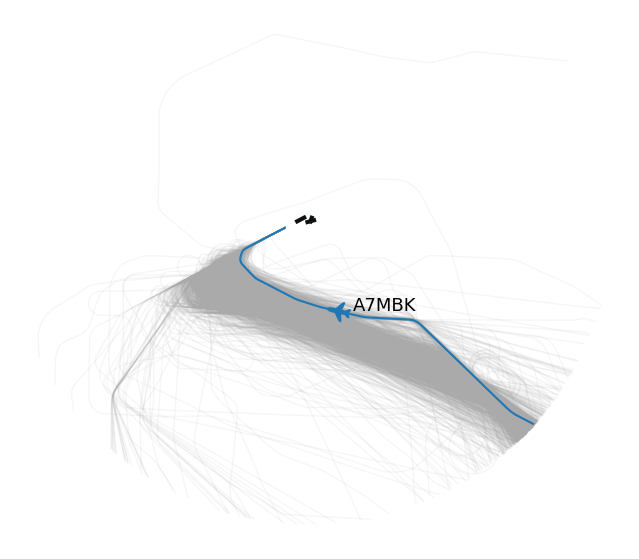

In [11]:
#Trajecotires are already normalized to begin at the same point

from traffic.core.projection import Lambert93
from traffic.data import airports

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    obs_ldng.plot(ax, alpha=0.1)

    k = 0
    obs_ldng[k].plot(ax, color="#1f77b4", lw=1.5)
    obs_ldng[k].at_ratio(0.5).plot(
        ax,
        color="#1f77b4",
        zorder=3,
    )

    airports["LFPO"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

plt.show()

In [12]:
end_time = obs_ldng.data.groupby("flight_id")["timestamp"].last().sort_values()

df_end_time = end_time.to_frame()
df_end_time["year"] = end_time.dt.year
df_end_time["month"] = end_time.dt.month
df_end_time["day"] = end_time.dt.day
df_end_time["hour"] = end_time.dt.hour
df_end_time["day_name"] = end_time.dt.day_name()
df_end_time = df_end_time.reset_index()
df_end_time.index = df_end_time.timestamp

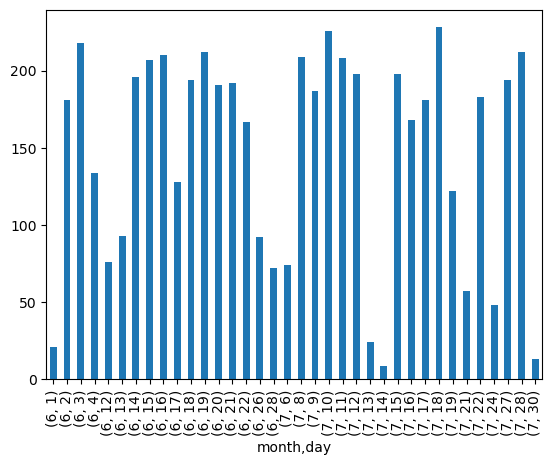

In [72]:
df_start_time.groupby(["month", "day"]).timestamp.count().plot.bar()
plt.show()

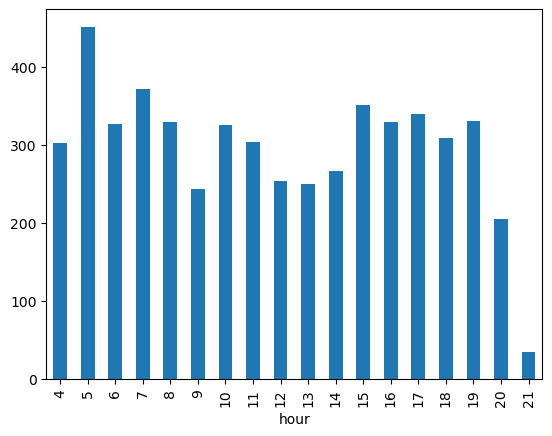

In [73]:
df_start_time.groupby(["hour"]).timestamp.count().plot.bar()
plt.show()

In [74]:
busy_days = df_end_time.groupby(["year", "month", "day"]).timestamp.count() > 100
busy_days = busy_days[busy_days==True].reset_index()[["year", "month", "day"]]
busy_days = pd.to_datetime(busy_days).astype(str)

#For every busiest days of the dataset (more than 200 movements)
#Get the time difference between two consecutives flights

dt_sec = {}
for i in tqdm(busy_days):
    delta_t = np.diff(df_end_time.loc[i].between_time('04:00','20:00').timestamp)
    helper = np.vectorize(lambda x: x.total_seconds())
    dt_sec[i] = helper(delta_t)

  0%|          | 0/23 [00:00<?, ?it/s]

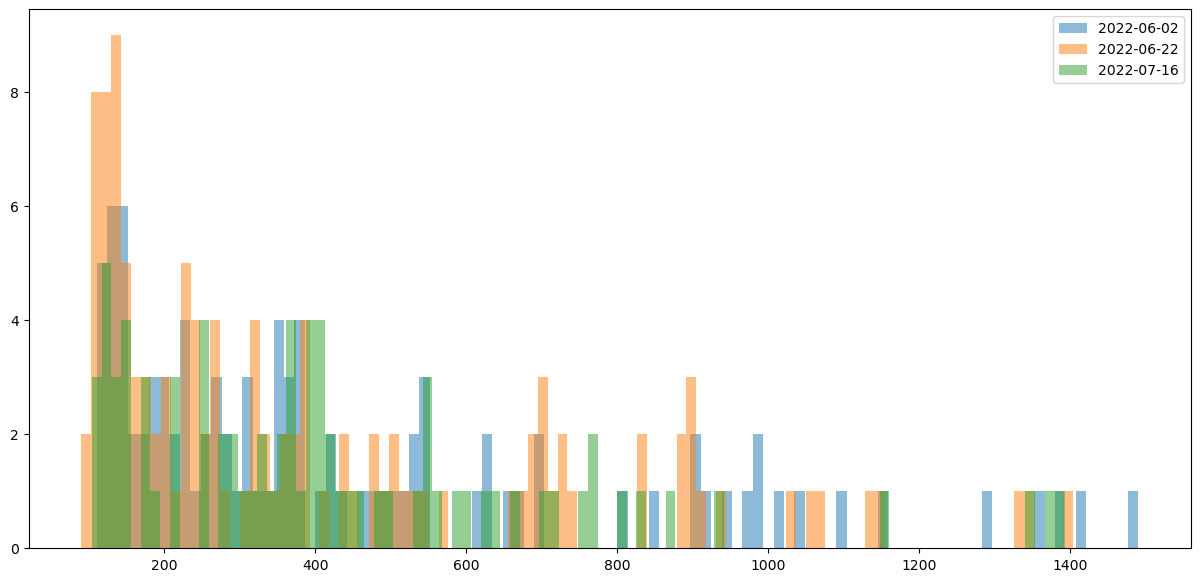

In [76]:
day1 = dt_sec[busy_days[0]][dt_sec[busy_days[0]] < 1500]
day2 = dt_sec[busy_days[1]][dt_sec[busy_days[1]] < 1500]
day3 = dt_sec[busy_days[2]][dt_sec[busy_days[2]] < 1500]

plt.figure(figsize=(15,7))
plt.hist(day1, 100, alpha=0.5, label=busy_days[0])
plt.hist(day2, 100, alpha=0.5, label=busy_days[10])
plt.hist(day3, 100, alpha=0.5, label=busy_days[17])
plt.legend(loc='upper right')
plt.show()

In [78]:
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

#Will the estimation be imporved with more samples ?
# https://stackoverflow.com/questions/37559470/what-do-all-the-distributions-available-in-scipy-stats-look-like/37559471#37559471

agg_delta_t = np.array([x for v in dt_sec.values() for x in v])
x = agg_delta_t#[agg_delta_t < 1500] #ATTENTION

#Exponential Law: waiting time between two events of a Poisson process -> Should be the one we use
dist_exp = st.expon
args_exp = dist_exp.fit(x) #x or agg_delta_t
print(st.kstest(x, dist_exp.cdf, args_exp)) #goodness of fit with KS test: p value very low: Reject the null hypothesis which states that the sample comes from an exponential distribution

#Other test: Birnbaum-Sanders distribution, which is typically used to model failure times
dist_fl = st.fatiguelife
args_fl = dist_fl.fit(x)
print(st.kstest(x, dist_fl.cdf, args_fl))
# Here BS seems very well adapter as we cannot reject the fact that they come from the same dstribution at level 10%

#KDE: Gaussian
# kde = KernelDensity(kernel="gaussian", bandwidth=11).fit(x.reshape(-1, 1))
params = {"bandwidth": np.logspace(-1, 2, 20)}
grid = GridSearchCV(KernelDensity(kernel="gaussian"), params)
grid.fit(x.reshape(-1, 1))
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

KstestResult(statistic=0.057456082959489896, pvalue=1.0252931577920747e-07)
KstestResult(statistic=0.02401352123134226, pvalue=0.10574326964438474)
best bandwidth: 33.59818286283781


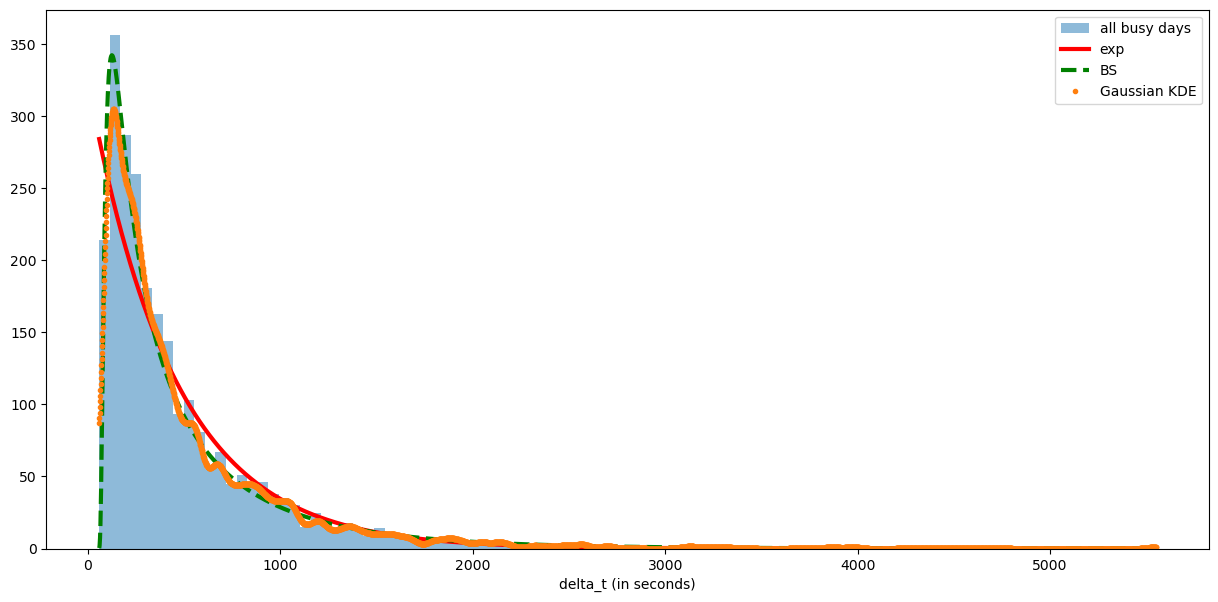

In [83]:
seconds = np.linspace(x.min(), x.max(), 5000)
dist_1 = dist_fl.pdf(seconds, *args_fl)
dist_2 = dist_exp.pdf(seconds, *args_exp)
log_dens = kde.score_samples(seconds[:, np.newaxis])
nbins = 100

fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.hist(x, 100, alpha=0.5, label="all busy days")
ax.plot(seconds, dist_2 * len(x) * 5000 / nbins,
        '-r', lw=3, label='exp')
ax.plot(seconds, dist_1 * len(x) * 5000 / nbins,
        '--g', lw=3, label='BS')
ax.plot(seconds, np.exp(log_dens)* len(x) * 5000 / nbins,
        '.', lw=3, label='Gaussian KDE')
ax.set_xlabel("delta_t (in seconds)")
ax.legend()
plt.show()

Parameters for BS distribution:  (1.146240535025501, 48.7344285250812, 275.39162289183787)


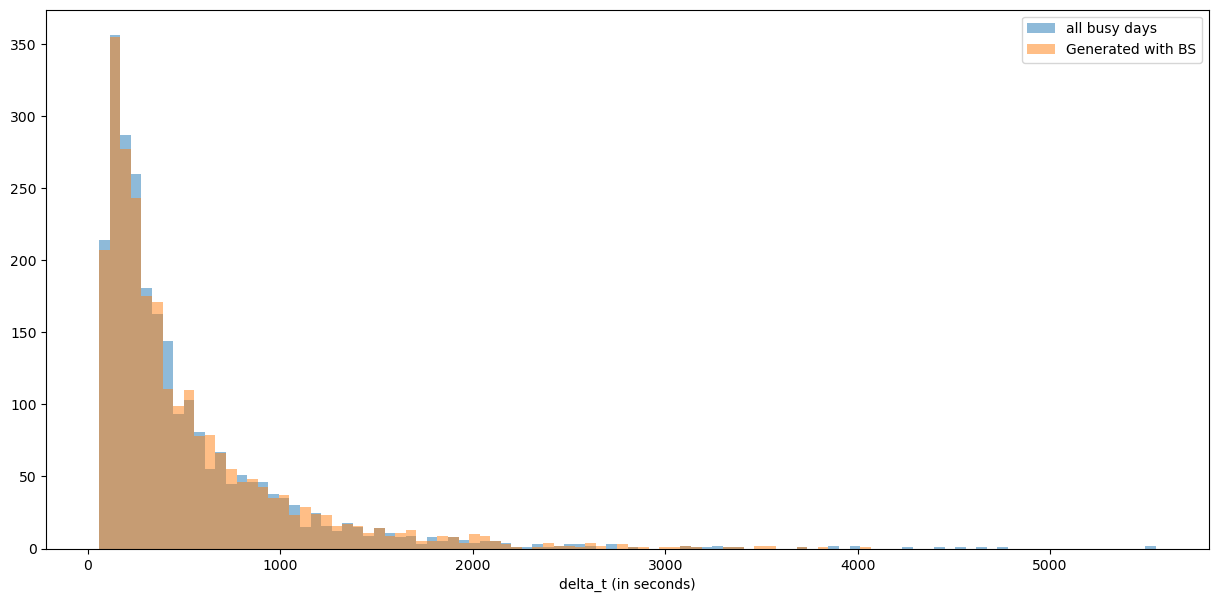

In [88]:
#WARNING: Loc and scale are different from mean and std
#WARNING: Bins cut in equal parts between min and max values. If for second distrib, they are different, bins are not the same size
y = dist_fl(*args_fl).rvs(size = len(x))
print("Parameters for BS distribution: ", args_fl)
bins=np.histogram(np.hstack((x,y)), bins=100)[1]

fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.hist(x, bins = bins, alpha=0.5, label="all busy days")
ax.hist(y, bins = bins, alpha=0.5, label="Generated with BS")
ax.set_xlabel("delta_t (in seconds)")
ax.legend()
plt.show()

Conclusion for time delta estimation :
- Take-offs to south are badly estimated (according to KS) by BS(1.2915832344015081, 49.84875673178755, 131.49841685902197). But samples generated seem reasonable. We also filtered the delta_t bigger than 2000 seconds
- Landings are well estimated by BS(1.146240535025501, 48.7344285250812, 275.39162289183787), and generated samples seem reasonnable. We don't filter bigger values. 
- If we want to estimate the joint distribution between the two, we could just add a bivariate copula.

# Flow parametrisation

In [42]:
# Generation of takeoff flow

import scipy.stats as st
import pandas as pd

dist_to = st.fatiguelife(c = 1.2915832344015081, loc = 49.84875673178755, scale = 131.49841685902197)
gen_dt_to = np.concatenate(([0],dist_to.rvs(len(gen_to)-1)))
cum_gen_dt_to = np.round(np.cumsum(gen_dt_to))

#dupplicate dt times the number of observations for each flights
cum_gen_dt_to_aug = []
counts = gen_to.basic_stats["count"].to_list()
for i, td in enumerate(cum_gen_dt_to):
    cum_gen_dt_to_aug.extend([td]*counts[i])
    
gen_to.data.timestamp = gen_to.data.timestamp + pd.to_timedelta(cum_gen_dt_to_aug, unit = "s")


In [43]:
pd.to_timedelta(cum_gen_dt_to[:5], unit = "s")

TimedeltaIndex(['0 days 00:00:00', '0 days 00:06:28', '0 days 00:08:04',
                '0 days 00:11:22', '0 days 00:13:32'],
               dtype='timedelta64[ns]', freq=None)

In [44]:
gen_to["TRAJ_0"] | gen_to["TRAJ_1"] | gen_to["TRAJ_2"] | gen_to["TRAJ_3"] | gen_to["TRAJ_4"]

In [45]:
gen_to = gen_to.assign(flight_id = lambda df: "TO_" + df.flight_id)

In [49]:
gen_to = gen_to.resample("5s").eval(desc = "", max_workers = 50)

Output()

In [53]:
# Generation of landing flow

import scipy.stats as st
import pandas as pd

dist_ldng = st.fatiguelife(c=1.146240535025501, loc=48.7344285250812, scale=275.39162289183787)
gen_dt_ldng = np.concatenate(([0],dist_ldng.rvs(len(gen_ldng)-1)))
cum_gen_dt_ldng = np.round(np.cumsum(gen_dt_ldng))

#dupplicate dt times the number of observations for each flights
cum_gen_dt_ldng_aug = []
counts = gen_ldng.basic_stats["count"].to_list()
for i, td in enumerate(cum_gen_dt_ldng):
    cum_gen_dt_ldng_aug.extend([td]*counts[i])
    
gen_ldng.data.timestamp = gen_ldng.data.timestamp + pd.to_timedelta(cum_gen_dt_ldng_aug, unit = "s")


In [55]:
pd.to_timedelta(cum_gen_dt_ldng[:5], unit = "s")

TimedeltaIndex(['0 days 00:00:00', '0 days 00:07:23', '0 days 00:09:34',
                '0 days 00:13:31', '0 days 00:21:29'],
               dtype='timedelta64[ns]', freq=None)

In [54]:
gen_ldng["TRAJ_0"] | gen_ldng["TRAJ_1"] | gen_ldng["TRAJ_2"] | gen_ldng["TRAJ_3"] | gen_ldng["TRAJ_4"]

In [56]:
gen_ldng = gen_ldng.assign(flight_id = lambda df: "LDNG_" + df.flight_id)

In [57]:
gen_ldng = gen_ldng.resample("5s").eval(desc = "", max_workers = 100)

Output()

In [58]:
all_trajs=Traffic(pd.concat((gen_to.data,gen_ldng.data)))

In [59]:
all_trajs["TO_TRAJ_0"].data

,timestamp,track,groundspeed,altitude,timedelta,flight_id,callsign,icao24,latitude,longitude,track_unwrapped
0,2022-09-22 12:07:00+00:00,74.397343,169.275002,2580.704545,0.000000,TO_TRAJ_0,TRAJ_0,TRAJ_0,48.736157,2.450310,74.397343
1,2022-09-22 12:07:05+00:00,74.458666,170.885689,2827.388804,5.997447,TO_TRAJ_0,TRAJ_0,TRAJ_0,48.737397,2.457109,74.458666
2,2022-09-22 12:07:10+00:00,75.360798,172.538533,3007.244849,10.849859,TO_TRAJ_0,TRAJ_0,TRAJ_0,48.738399,2.462663,75.360798
3,2022-09-22 12:07:15+00:00,76.681887,172.376887,3215.243186,15.856849,TO_TRAJ_0,TRAJ_0,TRAJ_0,48.739395,2.468454,76.681887
4,2022-09-22 12:07:20+00:00,81.522906,175.704655,3446.255628,22.083693,TO_TRAJ_0,TRAJ_0,TRAJ_0,48.740490,2.475730,81.522906
...,...,...,...,...,...,...,...,...,...,...,...
105,2022-09-22 12:15:45+00:00,158.344115,481.734787,25950.013943,526.209593,TO_TRAJ_0,TRAJ_0,TRAJ_0,47.983253,2.681746,158.344115
106,2022-09-22 12:15:50+00:00,158.033665,482.361262,26149.204301,531.497536,TO_TRAJ_0,TRAJ_0,TRAJ_0,47.972413,2.688177,158.033665
107,2022-09-22 12:15:55+00:00,158.482221,483.167579,26379.961984,536.755467,TO_TRAJ_0,TRAJ_0,TRAJ_0,47.961622,2.694605,158.482221
108,2022-09-22 12:16:00+00:00,158.881494,483.823423,26655.792987,542.603724,TO_TRAJ_0,TRAJ_0,TRAJ_0,47.949558,2.701625,158.881494


In [60]:
all_trajs["LDNG_TRAJ_0"].data

,timestamp,track,groundspeed,altitude,timedelta,flight_id,callsign,icao24,latitude,longitude,track_unwrapped
0,2022-09-22 12:07:00+00:00,308.258699,335.676543,16318.067800,0.000000,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.163452,3.237095,308.258699
1,2022-09-22 12:07:05+00:00,308.231887,336.765510,16304.268278,9.953046,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.173123,3.219345,308.231887
2,2022-09-22 12:07:10+00:00,309.381783,334.486329,16282.793936,13.977843,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.177036,3.212219,309.381783
3,2022-09-22 12:07:15+00:00,309.438856,336.244735,16323.581928,19.351684,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.182293,3.202662,309.438856
4,2022-09-22 12:07:20+00:00,307.928274,334.554736,16232.123728,24.192855,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.186854,3.193913,307.928274
...,...,...,...,...,...,...,...,...,...,...,...
189,2022-09-22 12:22:45+00:00,61.451123,129.596448,796.061230,947.619732,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.698271,2.255891,421.451123
190,2022-09-22 12:22:50+00:00,61.533002,129.908734,768.279111,951.556448,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.699387,2.259002,421.533002
191,2022-09-22 12:22:55+00:00,61.826233,130.833320,654.548348,958.180718,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.701260,2.264276,421.826233
192,2022-09-22 12:23:00+00:00,61.643712,130.193496,599.407187,964.465087,LDNG_TRAJ_0,TRAJ_0,TRAJ_0,48.703040,2.269258,421.643712


In [61]:
all_trajs.to_pickle("test_MC_orly.pkl")

In [74]:
mu = 1e-4
rel_err = 0.1
N = (1-mu)/(mu*rel_err**2)

In [75]:
N

999899.9999999999